# Molecule property regression with message-passing network

### Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch
import dgl
from dgl.data import QM9EdgeDataset
from tqdm import tqdm

/usr/local/anaconda/3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

### QM9EdgeDataset
DGL provides a preloaded interface to this dataset of 130k molecules
- https://docs.dgl.ai/en/0.8.x/generated/dgl.data.QM9EdgeDataset.html
- http://quantum-machine.org/datasets/

We want to train a graph neural network to regress the magnitude of the \
electric dipole moment $|\vec{\mu}|$ of the molecule, where:

$\vec{\mu} = \sum_{i} q_i \vec{x_i}$

In [3]:
data = QM9EdgeDataset(label_keys=['mu'])

Done loading data from cached files.


In [4]:
len(data)

130831

In [5]:
g, labels = data.__getitem__(100000)

In [7]:
from visualizer import draw_plotly
# draw_plotly(g)

ModuleNotFoundError: No module named 'plotly'

In [8]:
from model import MoleculeMPNN

In [9]:
net = MoleculeMPNN()

In [10]:
### number of parameters ###
sum(p.numel() for p in net.parameters())

371713

In [11]:
### Modified from https://docs.dgl.ai/en/0.2.x/tutorials/basics/4_batch.html ### 
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    labels = torch.row_stack(labels)
    return batched_graph, labels

In [12]:
train_dataset = torch.utils.data.Subset(data,range(100000))
valid_dataset = torch.utils.data.Subset(data,range(100000,105000))
test_dataset = torch.utils.data.Subset(data,range(110000,len(data)-1))

train_dataloader = DataLoader(train_dataset, batch_size=200, shuffle=True, collate_fn=collate, num_workers=4)
valid_dataloader = DataLoader(valid_dataset, batch_size=200, collate_fn=collate, num_workers=4)
test_dataloader  = DataLoader(test_dataset,  batch_size=1, collate_fn=collate, num_workers=0)

In [13]:
net(g)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (18x14 and 4x64)

In [14]:
from training import train_valid_loop

train_loss, valid_loss = train_valid_loop(net, train_dataloader, valid_dataloader, 10)

Found GPU!


 10%|█         | 1/10 [00:27<04:08, 27.60s/it]

Epoch:  0  Train loss:  1.8936867142915725  Valid loss:  1.293486545085907


 20%|██        | 2/10 [00:49<03:13, 24.14s/it]

Epoch:  1  Train loss:  1.273632706642151  Valid loss:  1.1632041430473328


 30%|███       | 3/10 [01:10<02:39, 22.84s/it]

Epoch:  2  Train loss:  1.2004174437522888  Valid loss:  1.0061922693252563


 40%|████      | 4/10 [01:32<02:14, 22.35s/it]

Epoch:  3  Train loss:  1.127458002448082  Valid loss:  0.9539897680282593


 50%|█████     | 5/10 [01:53<01:50, 22.09s/it]

Epoch:  4  Train loss:  1.091840084195137  Valid loss:  0.9031834530830384


 60%|██████    | 6/10 [02:15<01:27, 21.87s/it]

Epoch:  5  Train loss:  1.0641693485975265  Valid loss:  0.9177625668048859


 70%|███████   | 7/10 [02:37<01:05, 21.86s/it]

Epoch:  6  Train loss:  1.0253506964445114  Valid loss:  0.9504242742061615


 80%|████████  | 8/10 [02:58<00:43, 21.85s/it]

Epoch:  7  Train loss:  0.9943604085445404  Valid loss:  0.8368513810634614


 90%|█████████ | 9/10 [03:21<00:22, 22.18s/it]

Epoch:  8  Train loss:  0.9590085936784745  Valid loss:  0.81278768658638


100%|██████████| 10/10 [03:43<00:00, 22.36s/it]

Epoch:  9  Train loss:  0.9280005842447281  Valid loss:  0.8123299431800842


In [13]:
### Reload stored values ###
train_loss = np.load('train_loss.npy')
valid_loss = np.load('valid_loss.npy')

In [14]:
### Load saved model ###
net.load_state_dict(torch.load('saved_model.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

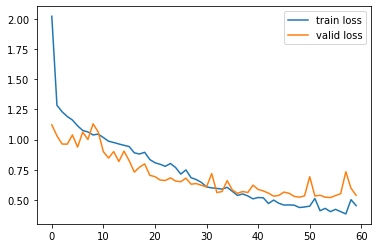

In [15]:
fig, axes = plt.subplots()
axes.plot(range(len(train_loss)),train_loss,label='train loss')
axes.plot(range(len(valid_loss)),valid_loss,label='valid loss')
#axes.set_yscale('log')
#axes.set_ylim([1e-2,1e0])
axes.legend()
plt.show()

In [16]:
preds, trues = [], []

for i in tqdm(range(len(test_dataset))):
    g, labels = test_dataset.__getitem__(i)
    preds.append(net(g).detach().numpy().item())
    trues.append(labels.item())

preds = np.array(preds)
trues = np.array(trues)

100%|██████████| 20830/20830 [06:40<00:00, 52.01it/s]


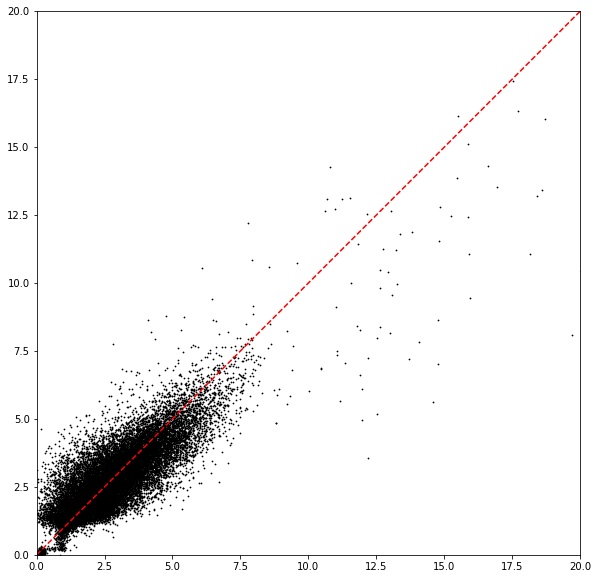

In [17]:
fig, axes = plt.subplots(figsize=(10,10))
axes.scatter(trues,preds,s=0.6,c='black')
axes.plot([0,20],[0,20],c='red',ls='--')
axes.set_xlim(0,20)
axes.set_ylim(0,20)
axes.set_aspect('equal')

Text(0.5, 0, 'pred - true / true')

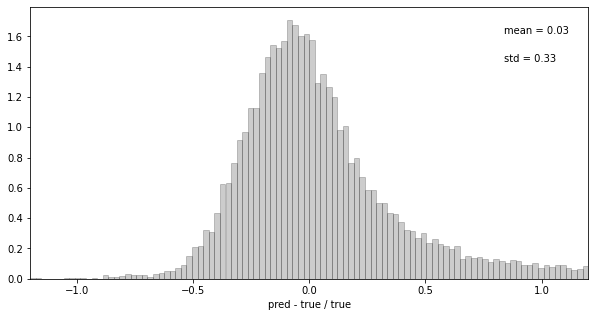

In [24]:
resids = (preds-trues)/(trues+1e-6)
resids = resids[abs(resids) < 1.2]

fig, axes = plt.subplots(figsize=(10,5))
h = axes.hist(resids,bins=100,range=(-1.2,1.2),facecolor='black',alpha=0.2,density=True,lw=1,edgecolor='black')
axes.set_xlim(-1.2,1.2)
axes.text(0.85,0.9,'mean = {:.2f}'.format(np.mean(resids)),transform=axes.transAxes)
axes.text(0.85,0.8,'std = {:.2f}'.format(np.std(resids)),transform=axes.transAxes)
axes.set_xlabel('pred - true / true')